# Asked Question

Can we predict the existence of a citation link between 2 articles? 

The data we have available is the articles information and a set of true/false links.

# Data Acquisition

In [1]:
# Pandas is used for data manipulation
import pandas as pd
from tqdm import tqdm

# Read in data as pandas dataframe and display first 5 rows
edges = pd.read_csv('input/training_set.txt', sep=" ", header=None, names=["id_source", "id_dest", "label"])
edges.head(5)

,id_source,id_dest,label
0,9510123,9502114,1
1,9707075,9604178,1
2,9312155,9506142,0
3,9911255,302165,0
4,9701033,209076,0


In [2]:
# We also read the nodes informations
infos = pd.read_csv('input/node_information.csv', sep=",", header=None, names=["id", "year", "title", "authors", "journal", "abstract"])
infos = infos.set_index('id')
# Authors are sperated by commas
# journal name is optional
# abstract is in lowercase

# We correct NaN to empty strings
infos[['title', 'authors', 'abstract', 'journal']] = infos[['title', 'authors', 'abstract', 'journal']].fillna('')
infos.head(5)

,year,title,authors,journal,abstract
id,,,,,
1001,2000,compactification geometry and duality,Paul S. Aspinwall,,these are notes based on lectures given at tas...
1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...
1003,2000,comment on metric fluctuations in brane worlds,"Y.S. Myung, Gungwon Kang",,recently ivanov and volovich hep-th 9912242 cl...
1004,2000,moving mirrors and thermodynamic paradoxes,Adam D. Helfer,Phys.Rev.,quantum fields responding to moving mirrors ha...
1005,2000,bundles of chiral blocks and boundary conditio...,"J. Fuchs, C. Schweigert",,proceedings of lie iii clausthal july 1999 var...


In [3]:
# We join our edges and features 
features = edges.join(infos, on='id_source')
features = features.join(infos, on='id_dest', lsuffix='_source', rsuffix='_dest')
features.head(5)

,id_source,id_dest,label,year_source,title_source,authors_source,journal_source,abstract_source,year_dest,title_dest,authors_dest,journal_dest,abstract_dest
0,9510123,9502114,1,1995,an infinite number of potentials surrounding 2...,,Phys.Lett.,we found an infinite number of potentials surr...,1995,stability analysis of the dilatonic black hole...,"Won T. Kim, Julian Lee, , Young Jai Park",Phys.Lett.,we explicitly show that the net number of degr...
1,9707075,9604178,1,1997,d 6 n 1 string vacua and duality,"L.E.Ibanez, A.M.Uranga",,winter school on duality mt sorak korea februa...,1996,strings on orientifolds,"Atish Dabholkar, Jaemo Park",Nucl.Phys.,we construct several examples of compactificat...
2,9312155,9506142,0,1993,conformal field theory and hyperbolic geometry,"P. Kleban, I. Vassileva",Phys.Rev.Lett.,we examine the correspondence between the conf...,1995,wightman functions behaviour on the event hori...,"V. Moretti (Dept. Phys. Univ. Trento Italy, INFN)",Class.Quant.Grav.,reissner-nordstr om black hole results followi...
3,9911255,302165,0,1999,comparing instanton contributions with exact r...,"Philip C. Argyres, Sophie Pell,",JHEP,supersymmetric scale invariant theories we dis...,2003,five-dimensional gauge theories and quantum me...,Timothy J. Hollowood,,we show how the dijkgraaf-vafa matrix model pr...
4,9701033,209076,0,1997,quantum gravitational measure for three-geomet...,,Phys.Lett.,that with some modifications was published in ...,2002,israel conditions for the gauss-bonnet theory ...,"Elias Gravanis, Steven Willison",,on the brane universe additional bulk fields a...


In [4]:
# We compute some information on our data to find relevant features
nbA = [0, 0]  # the label repartition for the presence of the author_dest in the abstract_source
nbT = [0, 0]  # the label repartition for the presence of the title_dest in the abstract_source
nbJ = {}  # the repartition of (min_len, intersection_len) of the journals (split by '.')
for index, row in tqdm(features.iterrows()):
    jd = set(row["journal_dest"].split('.'))
    if '' in jd:
        jd.remove('')
    js = set(row["journal_source"].split('.'))
    if '' in js:
        js.remove('')
    inter_len = len(js.intersection(jd))
    min_len = min(len(js), len(jd))
    if (inter_len, min_len) not in nbJ:
        nbJ[(inter_len, min_len)] = [0, 0]
    nbJ[(inter_len, min_len)][row["label"]] += 1
    
    nbCited = 0
    for author in row["authors_dest"].split():
        if author in row["abstract_source"]:
            nbCited += 1
    if nbCited > 0.5*len(row["authors_dest"].split()):
        nbA[row["label"]] += 1
    if row["title_dest"].lower() in row["abstract_source"]:
        nbT[row["label"]] += 1

nbA, nbT, nbJ

44546it [00:06, 6548.44it/s]


KeyboardInterrupt: 

# Identify Anomalies

In [5]:
print('The shape of our features is:', features.shape)

The shape of our features is: (615512, 13)


In [6]:
# Descriptive statistics for each column 
# features.describe(include='all')
features.describe()  # only numerical data

,id_source,id_dest,label,year_source,year_dest
count,6.155120e+05,6.155120e+05,615512.000000,615512.000000,615512.000000
mean,5.317422e+06,6.798460e+06,0.544474,1998.763452,1997.606771
std,4.749198e+06,4.343138e+06,0.498019,2.867817,2.945129
min,1.001000e+03,1.001000e+03,0.000000,1992.000000,1992.000000
25%,1.112660e+05,2.080790e+05,0.000000,1997.000000,1995.000000
50%,9.310036e+06,9.505058e+06,1.000000,1999.000000,1998.000000
75%,9.708050e+06,9.709097e+06,1.000000,2001.000000,2000.000000
max,9.912293e+06,9.912293e+06,1.000000,2003.000000,2003.000000


In [8]:
# We verify the d_source >= d_dest invariant
# 1. label == 1 => d_source >= d_dest 
# 2. d_source < d_dest => label == 0

# Verifying 2.
source_before = features[features['year_source'] < features['year_dest']]
print("Number of data with source published before target: {}".format(len(source_before)))
print("Number of links with a source published before the target: {} accounting for {:.2f}% percent of the cases of year_source < year_dest".format(
    source_before['label'].sum(),
    100. * source_before['label'].sum() / len(source_before)
))
source_1y_before = features[features['year_source'] < features['year_dest'] - 1]
print("Number of data with source published at least 1 year before target: {}".format(len(source_1y_before)))
print("Number of links with a source published at least 1 year before the target: {} accounting for {:.2f}% percent of the cases of year_source < year_dest".format(
    source_1y_before['label'].sum(),
    100. * source_1y_before['label'].sum() / len(source_before)
))

Number of data with source published before target: 129483
Number of links with a source published before the target: 2124 accounting for 1.64% percent of the cases of year_source < year_dest
Number of data with source published at least 1 year before target: 103882
Number of links with a source published at least 1 year before the target: 412 accounting for 0.32% percent of the cases of year_source < year_dest


In [9]:
source_before[source_before['label'] == 1].head(5)

,id_source,id_dest,label,year_source,title_source,authors_source,journal_source,abstract_source,year_dest,title_dest,authors_dest,journal_dest,abstract_dest
100,109122,202096,1,2001,anti-de sitter black hole thermodynamics in hi...,"Shin'ichi Nojiri, Sergei D. Odintsov",Phys.Lett.,and new confining-deconfining phases in dual c...,2002,ds cft correspondence in two dimensions,"Scott Ness, George Siopsis",Phys.Lett.,we discuss the quantization of a scalar partic...
456,9612164,9611050,1,1996,type iib instanton as a wave in twelve dimensions,,Phys.Rev.Lett.,0-brane of type iia string theory can be inter...,1997,tasi lectures on d-branes,Joseph Polchinski,,and clarifications more complete list of early...
1653,107131,106171,1,2001,string theory on ads 3 z n,John Son,,we study string theory on singular z n quotien...,2002,string theory on ads orbifolds,"Emil Martinec, Will McElgin",JHEP,spacetime cft interpretation we consider world...
1723,103046,6147,1,2001,skyrmions on the two-sphere,"M. de Innocentis, R.S. Ward",,we study static solutions of the skyrme model ...,2002,s 3 skyrmions and the rational map ansatz,Steffen Krusch,Nonlinearity,this paper discusses multi-skyrmions on the 3-...
1815,9708123,9705132,1,1997,usp 2k matrix model,"H. Itoyama, A. Tokura",Prog.Theor.Phys.,added the final version to appear in progress ...,1998,m atrix theory on t5 z2 orbifold and five-branes,"N. Kim, Soo-Jong Rey",Nucl.Phys.,we study m atrix theory description of m theor...


In [10]:
# Verifying 1.
links = features[features['label'] == 1]
print("{} true links".format(len(links)))
print("{:.2f}% of the true links are with year_source < year_dest".format(
    100. * len(links[links["year_source"] < links["year_dest"]]) / len(links)
))
print("{:.2f}% of the true links are with year_source < year_dest - 1".format(
    100. * len(links[links["year_source"] < links["year_dest"] - 1]) / len(links)
))


335130 true links
0.63% of the true links are with year_source < year_dest
0.12% of the true links are with year_source < year_dest - 1


# Data Preparation

### TITLES: tf-idf

To use the title information, we compute the tf-idf and compute a cross-product between the 2 titles

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# we compute the tfd-idf on all the title
# vectorizer = TfidfVectorizer(stop_words="english", token_pattern=u'(?ui)\\b\\w*[a-zA-Z0-9_]+\\w*\\b')  # to match 1 letter words
vectorizer = TfidfVectorizer(stop_words="english", token_pattern=u'(?u)\S+')  # to get hyphened words
features_TFIDF = vectorizer.fit_transform(infos["title"])
idf = vectorizer.idf_
tfidf_tmp = list(zip(vectorizer.get_feature_names(), idf))
tfidf_tmp.sort(key=lambda x: x[1], reverse=True)
tfidf_res = dict(tfidf_tmp)
tfidf_res

{'0212129': 10.538600409175375,
 '0a': 10.538600409175375,
 '1-5': 10.538600409175375,
 '1-cocycle': 10.538600409175375,
 '1-dimensions': 10.538600409175375,
 '1-form': 10.538600409175375,
 '1-gravity': 10.538600409175375,
 '1-soliton': 10.538600409175375,
 '1-time': 10.538600409175375,
 '1-wrapped': 10.538600409175375,
 '10-13': 10.538600409175375,
 '10-d': 10.538600409175375,
 '10-dimensional': 10.538600409175375,
 '10-form': 10.538600409175375,
 '10j': 10.538600409175375,
 '11-dimensions': 10.538600409175375,
 '11-p': 10.538600409175375,
 '12-dimensional': 10.538600409175375,
 '12j-symbols': 10.538600409175375,
 '12th': 10.538600409175375,
 '1976': 10.538600409175375,
 '1994': 10.538600409175375,
 '1k': 10.538600409175375,
 '1supergravity': 10.538600409175375,
 '2-branes': 10.538600409175375,
 '2-dimensions': 10.538600409175375,
 '2-dimentional': 10.538600409175375,
 '2-fermion': 10.538600409175375,
 '2-gravity': 10.538600409175375,
 '2-homogeneous': 10.538600409175375,
 '2-interact

In [12]:
# We compute the title tf-idf cross product for each edge
# distance function
stop_words = vectorizer.get_stop_words()
def dist_edge_titles(edge):
    return dist_titles(edge["title_source"], edge["title_dest"])

misses = 0
def dist_titles(t1, t2):
    # We could have tried to penalise the non appearance of the most important words for instance: could be useful for abstracts
    # t1_tfidf = []
    # for word in t1.split(" "):
    #     if word not in stop_words:
    #         t1_tfidf.append((tfidf_res[word], word))
    score = 0
    for word in set(t1.split()).intersection(set(t2.split())):
        if word not in stop_words:
            if word in tfidf_res:
                score += tfidf_res[word]
            else:
                print(word)
                global misses
                misses += 1
                score += 10.  # important !
    return score

from pprint import pprint
print(features.iloc[0]["title_source"])
t1_tfidf = []
for word in features.iloc[0]["title_source"].split(" "):
    if word not in stop_words:
        t1_tfidf.append((tfidf_res[word], word))
pprint(t1_tfidf)
print(features.iloc[0]["title_dest"])
t2_tfidf = []
for word in features.iloc[0]["title_dest"].split(" "):
    if word not in stop_words:
        t2_tfidf.append((tfidf_res[word], word))
pprint(t2_tfidf)
print(features.iloc[0]["label"])
dist_edge_titles(features.iloc[0])

an infinite number of potentials surrounding 2d black hole
[(6.997641085138062, 'infinite'),
 (7.171304579188901, 'number'),
 (6.60677477645105, 'potentials'),
 (10.538600409175375, 'surrounding'),
 (5.32366465156639, '2d'),
 (4.072455684937756, 'black'),
 (5.045538965834827, 'hole')]
stability analysis of the dilatonic black hole in two dimensions
[(6.513248718440226, 'stability'),
 (6.387560503276729, 'analysis'),
 (6.7319379194050555, 'dilatonic'),
 (4.072455684937756, 'black'),
 (5.045538965834827, 'hole'),
 (4.622398346567941, 'dimensions')]
1


9.117994650772584

In [13]:
import numpy as np

features['d_title'] = np.vectorize(dist_titles)(features["title_source"], features["title_dest"])
features[["title_source", "title_dest", "d_title", "label"]].head(5)

,title_source,title_dest,d_title,label
0,an infinite number of potentials surrounding 2...,stability analysis of the dilatonic black hole...,9.117995,1
1,d 6 n 1 string vacua and duality,strings on orientifolds,0.000000,1
2,conformal field theory and hyperbolic geometry,wightman functions behaviour on the event hori...,0.000000,0
3,comparing instanton contributions with exact r...,five-dimensional gauge theories and quantum me...,0.000000,0
4,quantum gravitational measure for three-geomet...,israel conditions for the gauss-bonnet theory ...,0.000000,0


In [14]:
print(misses)  # words not in our vacabulary

0


### AUTHORS: overlap divided by the max nb of authors

In [15]:
# We add author information 
def dist_edge_authors(edge):
    return authors_overlap(edge["authors_source"], edge["authors_dest"])

def authors_overlap(a1, a2):
    if a1 == '' or a2 == '':
        return 0.
    a1s = a1.split(",")    
    a2s = a2.split(",")
    max_len = max(len(a1s), len(a2s))  # always >= 1
    return (1. * len(set(a1s).intersection(set(a2s)))) / max_len  # which ratio is kept

i = 24
print(features.iloc[i][["authors_source", "authors_dest", "label"]])
dist_edge_authors(features.iloc[i])

authors_source                    S. Penati, D. Zanon
authors_dest      G.W. Delius, M.T. Grisaru, D. Zanon
label                                               1
Name: 24, dtype: object


0.3333333333333333

In [16]:
features['d_authors'] = np.vectorize(authors_overlap)(features["authors_source"], features["authors_dest"])
features[["authors_source", "authors_dest", "d_authors", "label"]].loc[24:30]

,authors_source,authors_dest,d_authors,label
24,"S. Penati, D. Zanon","G.W. Delius, M.T. Grisaru, D. Zanon",0.333333,1
25,,"Carl M. Bender, Kimball A. Milton",0.000000,0
26,Michael Martin Nieto,"Karl L, steiner",0.000000,0
27,Luca Lusanna (INFN Florence),"Takeshi Fukuda, Kazuo Hosomichi",0.000000,0
28,,,0.000000,1
29,"A.Mironov, A.Morozov","Jose D. Edelstein, Carlos Nunez",0.000000,0
30,"C. Schweigert, J. Fuchs, J. Walcher","J. Fuchs, C. Schweigert, J. Walcher",0.333333,1


### DATE: difference

In [47]:
# We add time difference
def dist_edge_date(edge):
    return date_diff(edge["year_dest"], edge["year_source"])

def date_diff(y1, y2):
    return y2 - y1

features['d_year'] = np.vectorize(date_diff)(features["year_source"], features["year_dest"])
features[["year_source", "year_dest", "d_year", "label"]].head(5)

,year_source,year_dest,d_year,label
0,1995,1995,0,1
1,1997,1996,-1,1
2,1993,1995,2,0
3,1999,2003,4,0
4,1997,2002,5,0


Text(0.5, 0.98, 'Date difference distribution for each label')

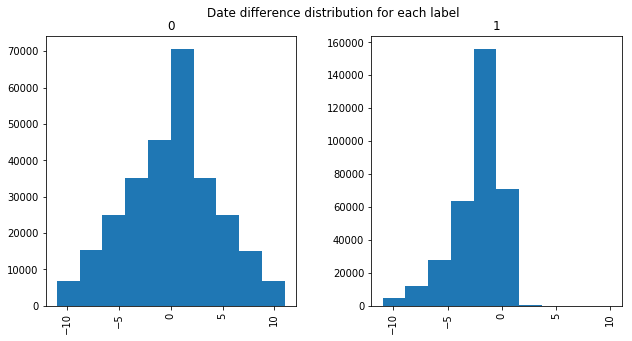

In [51]:
import pylab as pl

import matplotlib.pyplot as plt
features[["d_year", "label"]].hist(column="d_year",by="label", figsize=(10, 5))
pl.suptitle("Date difference distribution for each label")

### ABSTRACT: nothing so far

In [69]:
# we do nothing: done in feature_extractor.py

### JOURNAL: nothing

In [70]:
# Nothing either: done in feature_extractor.py

### Final features

In [71]:
print('Shape of features after data preparation:', features.shape)
features.loc[24:30]

Shape of features after data preparation: (615512, 16)


,id_source,id_dest,label,year_source,title_source,authors_source,journal_source,abstract_source,year_dest,title_dest,authors_dest,journal_dest,abstract_dest,d_title,d_authors,d_year
24,9501105,9202069,1,1995,quantum integrability in two-dimensional syste...,"S. Penati, D. Zanon",Phys.,in this paper we consider affine toda systems ...,1992,quantum conserved currents in affine toda theo...,"G.W. Delius, M.T. Grisaru, D. Zanon",Nucl.Phys.,we study the renormalization and conservation ...,3.523786,0.333333,-3
25,9712216,9802184,0,1997,two component theory and electron magnetic moment,,Acta,usa and cern geneva switzerland the two-compon...,1998,massless quantum electrodynamics with a critic...,"Carl M. Bender, Kimball A. Milton",,recently it has been observed that a quantum f...,0.000000,0.000000,1
26,5281,11003,0,2000,a simple volcano potential with an analytic ze...,Michael Martin Nieto,Phys.Lett.,we describe a simple volcano potential which i...,2000,quasi-particles in non-commutative field theory,"Karl L, steiner",,structures in mathematics and physics kyiv ukr...,0.000000,0.000000,0
27,9705154,105217,0,1997,unified description and canonical reduction to...,Luca Lusanna (INFN Florence),,the four interactions talk at the internationa...,2001,three-point functions in sine-liouville theory,"Takeshi Fukuda, Kazuo Hosomichi",JHEP,of fzz are made more precise we calculate the ...,0.000000,0.000000,4
28,9708164,9510017,1,1997,duality strings and supergravity,,,of mathematical physics 13-19 july 1997 brisba...,1995,dirichlet-branes and ramond-ramond charges,,Phys.Rev.Lett.,added to 11 we show that dirichlet-branes exte...,0.000000,0.000000,-2
29,107114,103167,0,2001,p q-duality and hamiltonian flows in the space...,"A.Mironov, A.Morozov",Phys.Lett.,integrable systems as canonical transforms of ...,2001,d6 branes and m theory geometrical transitions...,"Jose D. Edelstein, Carlos Nunez",JHEP,we study the supergravity duals of supersymmet...,0.000000,0.000000,0
30,11109,3298,1,2000,conformal field theory boundary conditions and...,"C. Schweigert, J. Fuchs, J. Walcher",,theory this is an introduction to two-dimensio...,2000,projections in string theory and boundary stat...,"J. Fuchs, C. Schweigert, J. Walcher",Nucl.Phys.,in string theory various projections have to b...,11.750286,0.333333,0


### Features and Labels and Convert Data to Arrays

In [72]:
# To avoid loosing all our feature computation before
features_copy = features.copy()

In [73]:
# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict
labels = np.array(features_copy['label'])

# Remove the labels from the features
# axis 1 refers to the columns
features = features_copy.drop('label', axis = 1)
# We also drop the useless columns
features = features.drop(['id_dest', 'id_source', 'authors_source', 'authors_dest', 'title_source', 'title_dest', 'abstract_source', 'abstract_dest', 'journal_dest', 'journal_source'], axis=1)
features.head(5)

,year_source,year_dest,d_title,d_authors,d_year
0,1995,1995,9.117995,0.0,0
1,1997,1996,0.000000,0.0,-1
2,1993,1995,0.000000,0.0,2
3,1999,2003,0.000000,0.0,4
4,1997,2002,0.000000,0.0,5


In [74]:
# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

### Training and Testing Sets

In [75]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)

In [76]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (461634, 5)
Training Labels Shape: (461634,)
Testing Features Shape: (153878, 5)
Testing Labels Shape: (153878,)


# Establish Baseline

In [77]:
# The baseline predictions are the historical averages
baseline_pred = 0.5

# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_pred - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  0.5


# Simple Model : Random Forest
## Train Model

In [78]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model 
rf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)

# Train the model on training data
rf.fit(train_features, train_labels);

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.1s finished


## Make Predictions on Test Data

In [79]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), '.')
print('Accuracy: {:.2f}%'.format((1 - np.mean(errors)) * 100))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s


Mean Absolute Error: 0.22 .
Accuracy: 77.70%


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.5s finished


## Improve Model

We can create models with different hyperparameters to try and boost performance. The only way to find the best ones
are to try a few and evaluate them! 

In [80]:
rf_new = RandomForestClassifier(n_estimators = 3, criterion = 'entropy', max_depth = 10, 
                               min_samples_split = 2, min_samples_leaf = 1, verbose=1, bootstrap=True, n_jobs=-1)
rf_new.fit(train_features, train_labels);
# Use the forest's predict method on the test data
predictions = rf_new.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), '.')
print('Accuracy: {:.2f}%'.format((1 - np.mean(errors)) * 100))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


Mean Absolute Error: 0.22 .
Accuracy: 77.90%


## Interpret Model Results

### Visualizing a Single Decision Tree

In [81]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydotplus

# Pull out one tree from the forest
tree = rf_new.estimators_[2]

# Export the image to a dot file
export_graphviz(tree, out_file = 'rf_data/tree.dot', feature_names = feature_list, class_names = ['No', 'Yes'], filled = True, rounded = True, precision = 1)

# Use dot file to create a graph
graph = pydotplus.graphviz.graph_from_dot_file('rf_data/tree.dot')

# Write graph to a png file
graph.write_png('rf_data/tree.png'); 

![Decision Tree](rf_data/tree.png)

In [82]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 10


### Smaller tree for visualization.

In [83]:
# Limit depth of tree to 2 levels
rf_small = RandomForestClassifier(n_estimators=7, max_depth = 3, random_state=42, verbose=1, n_jobs=-1)
rf_small.fit(train_features, train_labels)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Export the image to a dot file
export_graphviz(tree_small, out_file = 'rf_data/small_tree.dot', feature_names = feature_list, class_names = ['No', 'Yes'], filled = True, rounded = True, precision = 1)

# Use dot file to create a graph
graph = pydotplus.graphviz.graph_from_dot_file('rf_data/small_tree.dot')

# Write graph to a png file
graph.write_png('rf_data/small_tree.png'); 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s finished


![Small Decision Tree](rf_data/small_tree.PNG)

## Variable Importances

In [84]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: d_year               Importance: 0.56
Variable: d_title              Importance: 0.29
Variable: year_source          Importance: 0.06
Variable: year_dest            Importance: 0.05
Variable: d_authors            Importance: 0.03


## Model with Two Most Important Features

In [85]:
# New random forest with only the two most important variables
rf_most_important = RandomForestClassifier(n_estimators= 200, random_state=42, verbose=1, n_jobs=-1)

# Extract the two most important features
important_indices = [feature_list.index('d_year'), feature_list.index('d_title')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), '.')
print('Accuracy: {:.2f}%'.format((1 - np.mean(errors)) * 100))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   14.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s


Mean Absolute Error: 0.23 .
Accuracy: 77.25%


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.6s finished


## Visualizations

### Variable Importances

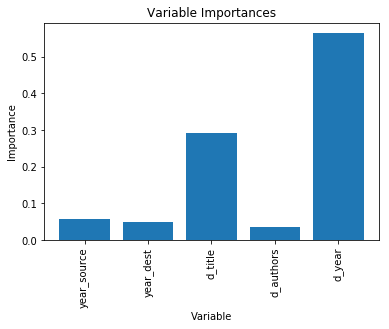

In [86]:
import matplotlib.pyplot as plt

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

### Examine the Default Random Forest to Determine Parameters

We will use these parameters as a starting point. I relied on the [sklearn random forest documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to determine which features to change and the available options.

In [87]:
rf = RandomForestClassifier(random_state = 42)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


# Random Search with Cross Validation

In [88]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [98]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 40, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(train_features, train_labels)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 42.6min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 229.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=40, n_jobs=-1,
          param_distributions={'n_estimators': [100, 119, 138, 157, 176, 195, 215, 234, 253, 272, 291, 311, 330, 349, 368, 387, 407, 426, 445, 464, 483, 503, 522, 541, 560, 579, 598, 618, 637, 656, 675, 694, 714, 733, 752, 771, 790, 810, 829, 848, 867, 886, 906, 925, 944, 963, 982, 1002, 1021, 1040, 1059, 107..., None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dis

In [90]:
rf_random.best_params_

{'n_estimators': 1923,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': True}

## Evaluation Function

In [95]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels).sum()  # nb of errors
    accuracy = (1 - 1. * errors / len(test_features)) * 100
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))

#### Evaluate the Default Model

In [99]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42, verbose=1)
base_model.fit(train_features, train_labels)
evaluate(base_model, test_features, test_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model Performance
Accuracy = 77.68%.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


#### Evaluate the Best Random Search Model

In [100]:
best_random = rf_random.best_estimator_
evaluate(best_random, test_features, test_labels)

Model Performance
Accuracy = 77.90%.
